## Practical Machine Learning Tutorial, Multi-class Classification Problem: Geoscience example (Facies)

[Ryan A. Mardani](https://www.linkedin.com/in/amardani/)

In this project, we will implement standard and comprehensive steps to select the best model and hyper prameters to predict rock facies form a dataset. First, we will prepare data for modeling, fit the models and cross validate, predict facies labels and evaluate prediction accuracy by several model evaluation metrics. Finally, we will examine model performance on blind-well data. These are the models that we will use:<br>
1 - Logistic Regression Classifier <br>
2 - K Neighbors Classifier<br>
3 - Decision Tree Classifier<br>
4 - Random Forest Classifier<br>
5 - Support Vector Classifier<br>
6 - Gaussian Naive Bayes Classifier<br>
7 - Gradient Boosting Classifier<br>
8 - Extra Tree Classifier<br>

The dataset for this study comes from Hugoton and Panoma Fields in North America which was used as class exercise at The University of Kansas (Dubois et. al, 2007). It consists of log data(the measurement of physical properties of rocks) of nine wells. We will use these log data to train supervised classifiers in order to predict discrete facies groups. For more detail, you may take a look here. The seven features are:<br>

__GR__: this wireline logging tools measure gamma emission<br>
__ILD_log10__: this is resistivity measurement<br>
__PE__: photoelectric effect log<br>
__DeltaPHI__: Phi is a porosity index in petrophysics.<br>
__PNHIND__: Average of neutron and density log.<br>
__NM_M__:nonmarine-marine indicator<br>
__RELPOS__: relative position<br>

The nine discrete facies (classes of rocks) are:<br>
(SS) Nonmarine sandstone<br>
(CSiS) Nonmarine coarse siltstone<br>
(FSiS) Nonmarine fine siltstone<br>
(SiSH) Marine siltstone and shale<br>
(MS) Mudstone (limestone)<br>
(WS) Wackestone (limestone)<br>
(D) Dolomite<br>
(PS) Packstone-grainstone (limestone)<br>
(BS) Phylloid-algal bafflestone (limestone)<br>
For more detailand data explanation refer [here](https://github.com/mardani72/Facies-Classification-Machine-Learning/blob/master/Facies_Classification_Various_ML_Final.ipynb). <br>
The project content:

#### __1- Data Exploratory Analysis__
> 1-1 Data visualization 
>> 1-1-1 log-plot<br>
>> 1-1-2 Bar plot<br>
>> 1-1-3 Cross-plot<br>

> 1-2 Feature Engineering<br> 
>> 1-2-1 NaN imputation<br>
>> 1-2-2 Feature extraction<br>
>> 1-2-3 Oversampling<br>

> 1-3 Feature Importance<br> 
>> 1-3-1 Feature linear corrolation<br>
>> 1-3-2 Decision tree<br>
>> 1-3-3 Permutation feature importance<br>

#### __2- Build Model & Validate__
> 2-1 Baseline Model<br> 
> 2-2 Hyper-parameters
>> 2-2-1 Grid search<br>

#### __3- Model Evaluation-1__
> 3-1 Model Merices <br>
> 3-2 Confusion matrix <br>
#### __4- Model Evaluation-2__
> 4-1 Learning curves<br> 
> 4-2 ROC plot<br> 
> 4-3 Blind well prediction and evaluation<br> 

In [1]:
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import LabelEncoder
from collections import Counter
pd.set_option('display.max_rows', 30)
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('facies_vectors.csv')

In [3]:
# specify some data types may python concern about
df['Facies'] = df['Facies'].astype('int')
df['Depth'] = df['Depth'].astype('float')
df['Well Name'] = df['Well Name'].astype('category')

### 1-1 Data visualization 
#### 1-1-1 log-plot

In [4]:
# colors 
facies_colors = ['xkcd:goldenrod', 'xkcd:orange','xkcd:sienna','xkcd:violet',
       'xkcd:olive','xkcd:turquoise', "xkcd:yellowgreen", 'xkcd:indigo', 'xkcd:blue']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 
                 'MS',  'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
#establish facies label str    
df.loc[:,'FaciesLabels'] = df.apply(lambda row: label_facies(row, facies_labels), axis=1)

In [5]:
data=df

This is function to create a plot.

In [6]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(12, 6))
    ax[0].plot(logs.GR, logs.Depth, '-g',  alpha=0.8, lw = 0.9)
    ax[1].plot(logs.ILD_log10, logs.Depth, '-b',  alpha=0.8, lw = 0.9)
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-k',  alpha=0.8, lw = 0.9)
    ax[3].plot(logs.PHIND, logs.Depth, '-r',  alpha=0.8, lw = 0.9)
    ax[4].plot(logs.PE, logs.Depth, '-c',  alpha=0.8, lw = 0.9)
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((5*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

In [7]:
data['Well Name'].unique()

[SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (10, object): [SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, ..., NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

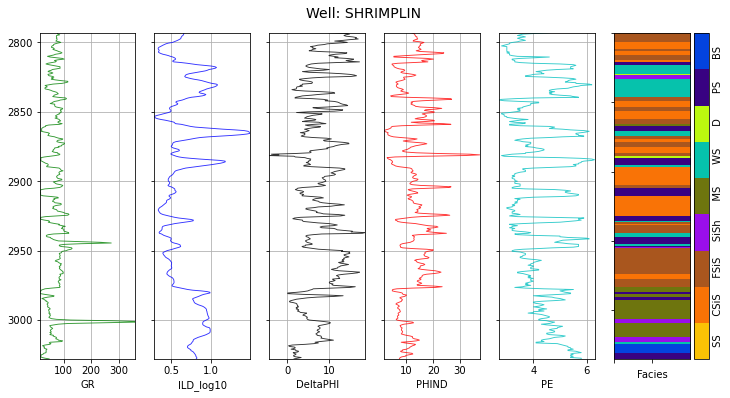

In [8]:
make_facies_log_plot(
    data[data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)
# plt.savefig("Well_example.png", dpi=400)

#### 1-1-2 Histogram

Let's facies percentages first:

In [9]:
cn = Counter(data.FaciesLabels)
for i,j in cn.items():
    percent = j / len(data) * 100
    print('Class=%s, Count=%d, Percentage=%.3f%%' % (i, j, percent))

Class=FSiS, Count=780, Percentage=18.800%
Class=CSiS, Count=940, Percentage=22.656%
Class=PS, Count=686, Percentage=16.534%
Class=WS, Count=582, Percentage=14.027%
Class=D, Count=141, Percentage=3.398%
Class=SiSh, Count=271, Percentage=6.532%
Class=MS, Count=296, Percentage=7.134%
Class=BS, Count=185, Percentage=4.459%
Class=SS, Count=268, Percentage=6.459%


Text(0, 0.5, 'Frequency')

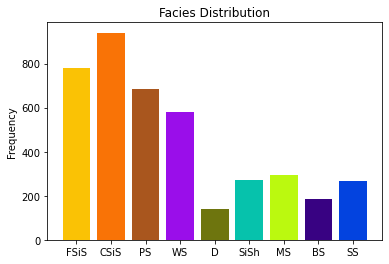

In [10]:
plt.bar(cn.keys(), cn.values(), color=facies_colors )
plt.title('Facies Distribution')
plt.ylabel('Frequency')
# plt.savefig("bar_plot.png", dpi=400)

This is imbalanced dataset. Dolomite has the lowest member participation. Comparing coarse siltstone, dolomite appears 8 times less than that.

#### 1-1-3 Cross-plot

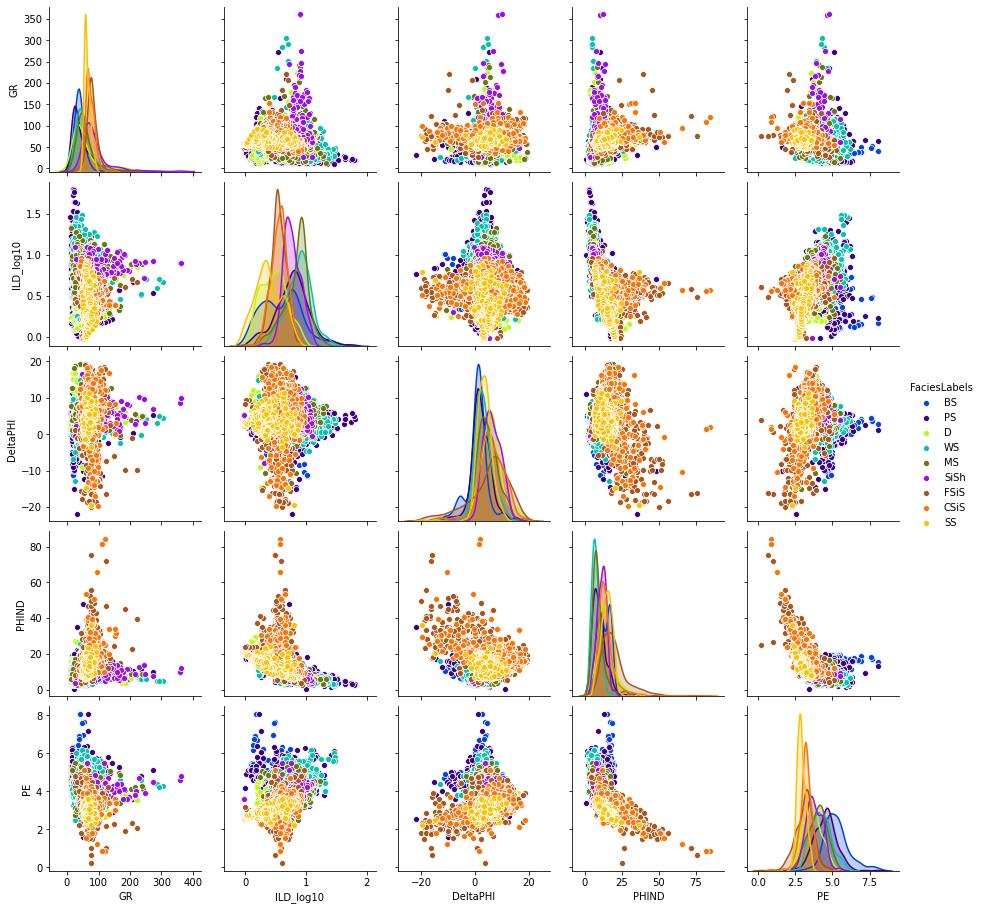

In [11]:
sns_plot = sns.pairplot(data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))
sns_plot.savefig('cross_plots.png')

##### Hereafter we will store dataset into new vriable after main operations (indented paragrpahs in introduction).

In [12]:
data_fe = data

#### 1-2 Feature Engineering 
##### 1-2-1 NaN imputation
Let's look at the data to see if Null values are present in dataset.

In [13]:
data_fe.isna().sum()

Facies            0
Formation         0
Well Name         0
Depth             0
GR                0
ILD_log10         0
DeltaPHI          0
PHIND             0
PE              917
NM_M              0
RELPOS            0
FaciesLabels      0
dtype: int64

In [14]:
# to find out which wells do not have PE
df_null = data_fe.loc[data_fe.PE.isna()]
df_null['Well Name'].unique()

[ALEXANDER D, KIMZEY A, Recruit F9]
Categories (3, object): [ALEXANDER D, KIMZEY A, Recruit F9]

There are sevral way to deal with Null values in dataset. The simplest approach is to drop the rows containing at least one null value. This can be logical with bigger size dataset but with small sized dataframes single points are important. We can impute null values with mean or from adjecent data points in columns. Filling with mean value will not affect data variance and therefore will not have impact on pediction accuracy, though can create data bias. Another approach, which I will implement here, to employe machine learning models to predict missing values. This is the best way of dealing with this dataset becuase we have just single feature missing from dataset, PE. There is meaningful corrolation between this feature with others. 

In [15]:
data_fe.corr()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
Facies,1.000000,0.306688,-0.386677,0.383166,-0.235005,-0.356453,0.704231,0.852721,0.076761
Depth,0.306688,1.000000,-0.088636,0.202272,0.067694,-0.095834,0.277577,0.282318,0.001537
GR,-0.386677,-0.088636,1.000000,-0.205855,0.178863,0.270729,-0.289023,-0.316284,-0.182051
ILD_log10,0.383166,0.202272,-0.205855,1.000000,-0.104827,-0.544416,0.384589,0.493570,0.088227
DeltaPHI,-0.235005,0.067694,0.178863,-0.104827,1.000000,-0.189355,0.011489,-0.177500,0.022470
PHIND,-0.356453,-0.095834,0.270729,-0.544416,-0.189355,1.000000,-0.573418,-0.481024,-0.033328
PE,0.704231,0.277577,-0.289023,0.384589,0.011489,-0.573418,1.000000,0.657089,0.018905
NM_M,0.852721,0.282318,-0.316284,0.493570,-0.177500,-0.481024,0.657089,1.000000,0.034015
RELPOS,0.076761,0.001537,-0.182051,0.088227,0.022470,-0.033328,0.018905,0.034015,1.000000


We can use various ML models to predict PE log as countinious regression problem. Here, I will employ Multi-Layer Percepteron Neural Network from scikit-learn to predict target value. I am not going to deep for this approach and use simply to predict missing values.

In [16]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

In [17]:
set_PE = data_fe[['Facies','Depth', 'GR', 'ILD_log10',
       'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']].dropna()  # select features and target log that has value
X = set_PE[['Facies','Depth', 'GR', 'ILD_log10',
       'DeltaPHI', 'PHIND', 'NM_M', 'RELPOS']]  # feature selection without null value
XX = data_fe[['Facies','Depth', 'GR', 'ILD_log10',
       'DeltaPHI', 'PHIND', 'NM_M', 'RELPOS']]
y = set_PE['PE'] # target log
# scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_b = scaler.fit_transform(XX)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
%%time
MLP_pe = MLPRegressor(random_state=1, max_iter= 500).fit(X_train, y_train) #fit the model
MLP_pe.score(X_test, y_test) # examine accuracy

Wall time: 36.7 s


C:\Users\Alireza\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.776094801295609

In [19]:
data_fe['PE_pred'] = MLP_pe.predict(X_b)  # predict PE
data_fe.PE.fillna(data_fe.PE_pred, inplace =True) # fill NaN vakues with predicted PE

###### Plot predecited PE

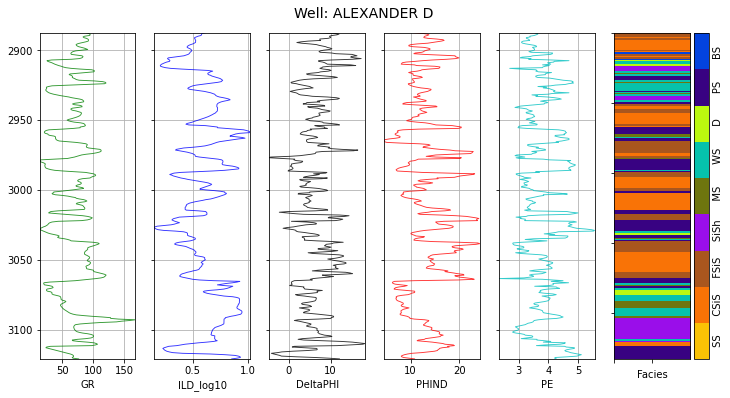

In [20]:
make_facies_log_plot(
    data[data['Well Name'] == 'ALEXANDER D'],
    facies_colors)
plt.savefig("predicted_PE.png", dpi=400)

In [21]:
# remove predicted PE column
data_fe = data_fe.drop(columns=['PE_pred'])
data = data.drop(columns=['PE_pred'])

#### 1-2-2 Feature extraction

Having limited set of features in this dataset can lead us to think about extracting some data from existing dataset.

First, we can convert formation categorical data into numeric data. Our background knowledge can help us to predict that some facies are possibly presnet more in a specififc formation rather than others.

In [22]:
# convert formation category data into numeric to use as predictor, add 1 starting from 1
data_fe['Formation_num'] = LabelEncoder().fit_transform(data_fe['Formation'].astype('str')) + 1

In [23]:
data_fe['Well Name'].unique()

[SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (10, object): [SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, ..., NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

#### Pick up a well as blind: 
machine learning algorithm will not see this data in the training process. We will use it at the end to see how the model works. Remember to select a well that includes all types of facies classes, otherwise in prediction, data dimension inconsistency will generate an error. Or simply add a lacking facies example to the well to avoid the problem.

In [24]:
blind = data_fe[data_fe['Well Name'] == 'KIMZEY A']
data_fe = data_fe[data_fe['Well Name'] != 'KIMZEY A']

To see if new feature extraction would assisst prediction improvment, we should define a baseline model then compare with extracted feature model.
##### Baseline Model Performance

In [25]:
X = data_fe[['Depth', 'GR', 'ILD_log10','DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS', 'Formation_num']]
y = data_fe['Facies']

In [26]:
from numpy import mean
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

For simplicity we will use logistic regression classifier as baseline model and will examine model performance with cross validation concept. Data will be splitted into 10 subgroups and process will be reapeted 3 times.

In [27]:
model = LogisticRegression(solver='liblinear')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f' % (mean(scores)))

Accuracy: 0.573


Here, we can explore whether feature extraction can improve model performance. There are many aprroaches while we will use some transforms for chaining the distribution of the input variables such as Quantile Transformer and KBins Discretizer. Then, will remove linear dependecies between the input variables using PCA and TruncatedSVD.
To study more refer [here](https://machinelearningmastery.com/quantile-transforms-for-machine-learning/).<br>
Using feature union class, we will define list of transforms to perform results aggrigated together. This will create a dataset with lots of feature columns while we need to reduce dimentionality to faster and better performance. Finally, Recursive Feature Elimination, or RFE, technique can be used to select the most relevent features. We select 30 features. 

In [28]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
#-------------------------------------------------- append transforms into a list
transforms = list()
transforms.append(('qt', QuantileTransformer(n_quantiles=100, output_distribution='normal')))
transforms.append(('kbd', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')))
transforms.append(('pca', PCA(n_components=7)))
transforms.append(('svd', TruncatedSVD(n_components=7)))
#-------------------------------------------------- initialize the feature union
fu = FeatureUnion(transforms)
#-------------------------------------------------- define the feature selection
rfe = RFE(estimator=LogisticRegression(solver='liblinear'), n_features_to_select=30)
#-------------------------------------------------- define the model
model = LogisticRegression(solver='liblinear')
#-------------------------------------------------- use pipeline to chain operation
steps = list()
steps.append(('fu', fu))
steps.append(('rfe', rfe))
steps.append(('ml', model))
pipeline = Pipeline(steps=steps)
# define the cross-validation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f' % (mean(scores)))

Accuracy: 0.614
Wall time: 58.6 s


Accuracy improvement shows that feature extraction can be useful approach when we are dealing with limited features in dataset.

#### 1-2-3 Oversampeling

In imbalanced datasets, we can use resampling technique to add some more data point to increase members of minority groups. This can be helpful whenever minority label targets has special importance such as credit card fraud detection. In that example, fraud can happen with less than 0.1 percent of transaction while it is important to detect fraud.<br>
In this work, we will add psudo observation for Dolomite class which has the lowest poulation

__Synthetic Minority Oversampling Technique, SMOTE__: the technique is used to select nearest neighbors in the feature space, separated examples by adding a line and producing new examples along the line. The method is not merely generating the duplicates from the outnumbered class, but applied K-nearest neighbours to generate synthetic data.

In [29]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

In [30]:
X_sm1 , y_sm1 = smote.fit_sample(X,y)
X_sm , y_sm = X_sm1 , y_sm1  # keep for fuuture plotting an cimparision

In [31]:
print("Before SMOTE: ", Counter(y))
print("After SMOTE: ", Counter(y_sm))

Before SMOTE:  Counter({2: 855, 3: 706, 8: 596, 6: 531, 1: 259, 5: 243, 4: 228, 9: 178, 7: 114})
After SMOTE:  Counter({3: 855, 2: 855, 8: 855, 6: 855, 7: 855, 4: 855, 5: 855, 9: 855, 1: 855})


Now, dataset is balanced. Let's see how works comparing Baseline model:

In [32]:
scaler = StandardScaler()
X_sm = scaler.fit_transform(X_sm)

In [33]:
model_bal = LogisticRegression(solver='liblinear')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model_bal, X_sm, y_sm, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f' % (mean(scores)))

Accuracy: 0.617


Accuracy improved by 3 percent but in multi-class classification, accuracy is not the best evaluation metrics. We will cover others in next parts.

In [34]:
data_fi = data

#### 1-3 Feature Importance
Some machine learning algorithms offer importance score to help the user to select the most efficient features for prediction.
##### 1-3-1 Feature linear corrolation

The concept is simple: features have higher correlation coefficient with target values are important for prediction. We can extract these coef's like: 

Feature: 0, Score: 0.00118
Feature: 1, Score: -0.00720
Feature: 2, Score: -0.41975
Feature: 3, Score: -0.03076
Feature: 4, Score: 0.05193
Feature: 5, Score: 0.93043
Feature: 6, Score: 3.39447
Feature: 7, Score: 0.32392
Feature: 8, Score: -0.01335


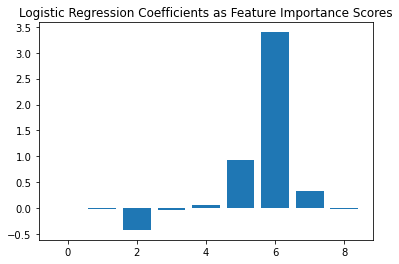

In [35]:
# logistic regression for feature importance
from sklearn.datasets import make_classification
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
# define dataset
model = LinearRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.title('Logistic Regression Coefficients as Feature Importance Scores')
pyplot.savefig('reg_importance.png')
pyplot.show()

##### 1-3-2 Decision tree
This algorithm provides importance scores based on the reduction in the criterion used to split in each node such as entropy or Gini.

Feature: 0, Score: 0.18993
Feature: 1, Score: 0.10106
Feature: 2, Score: 0.11655
Feature: 3, Score: 0.07372
Feature: 4, Score: 0.10396
Feature: 5, Score: 0.07612
Feature: 6, Score: 0.17064
Feature: 7, Score: 0.11935
Feature: 8, Score: 0.04867


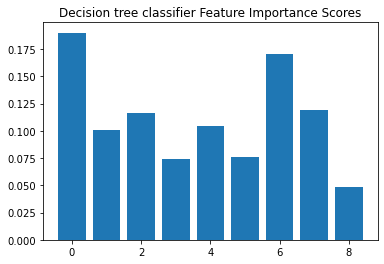

In [36]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.title('Decision tree classifier Feature Importance Scores')
pyplot.savefig('DTree.png')
pyplot.show()

XGBoost is a library that provides an efficient and effective implementation of the stochastic gradient boosting algorithm. This algorithm can be used with scikit-learn via the XGBRegressor and XGBClassifier classes.

Feature: 0, Score: 0.03433
Feature: 1, Score: 0.03754
Feature: 2, Score: 0.03386
Feature: 3, Score: 0.02545
Feature: 4, Score: 0.04048
Feature: 5, Score: 0.04242
Feature: 6, Score: 0.69899
Feature: 7, Score: 0.03016
Feature: 8, Score: 0.05678


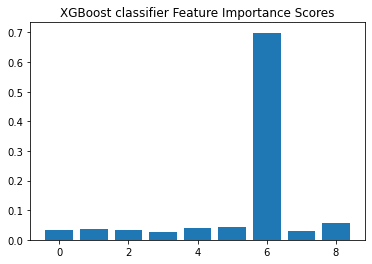

In [37]:
#pip install xgboost
from xgboost import XGBClassifier
model = XGBClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.title('XGBoost classifier Feature Importance Scores')
pyplot.show()

##### 1-3-3 Permutation feature importance

[Permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html) is a model inspection technique that can be used for any fitted estimator when the data is tabular. This is especially useful for non-linear or opaque estimators. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled.

Feature: 0, Score: -0.00226
Feature: 1, Score: 0.02755
Feature: 2, Score: 0.05337
Feature: 3, Score: 0.02722
Feature: 4, Score: 0.10911
Feature: 5, Score: 0.08243
Feature: 6, Score: 0.28561
Feature: 7, Score: 0.02792
Feature: 8, Score: 0.02528


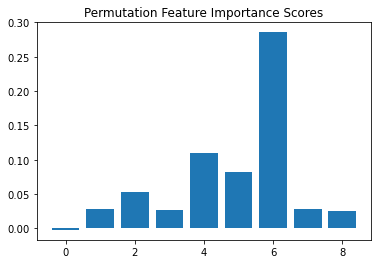

In [38]:
from sklearn.inspection import permutation_importance
model = LogisticRegression(solver='liblinear')
# fit the model
model.fit(X, y)
# perform permutation importance
results = permutation_importance(model, X, y, scoring='accuracy')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.title('Permutation Feature Importance Scores')
pyplot.savefig('permu.png')
pyplot.show()

### __2__ Build Model & Validate
#### 2-1 Baseline Model

The philosophy of constructing a baseline model is simple: we need a basic and simple model to see how the adjustments on both data and model parameters can cause improvement in model performance. In fact, this is like a scale for comparison.

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [40]:
# define Classifiers
log = LogisticRegression()  
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier()
rtree = RandomForestClassifier()
svm = SVC()
nb = GaussianNB()
gbc = GradientBoostingClassifier()
etree = ExtraTreesClassifier()

In [41]:
# define a function that uses pipeline to impelement data transformation and fit with model then cross validate
def baseline_model(model_name):

    model = model_name
    steps = list()
    steps.append(('ss', StandardScaler() ))
    steps.append(('ml', model))
    pipeline = Pipeline(steps=steps)

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
     # balanced X,y from SMOTE can also be used 
    scores = cross_val_score(pipeline, X_sm, y_sm, scoring='accuracy', cv=cv, n_jobs=-1)

    print(model,'Accuracy: %.3f' % (mean(scores)))

In [42]:
%%time
baseline_model(log)
baseline_model(knn)
baseline_model(dtree)
baseline_model(rtree)
baseline_model(svm)
baseline_model(nb)
baseline_model(gbc)
baseline_model(etree)

LogisticRegression() Accuracy: 0.627
KNeighborsClassifier() Accuracy: 0.875
DecisionTreeClassifier() Accuracy: 0.851
RandomForestClassifier() Accuracy: 0.913
SVC() Accuracy: 0.774
GaussianNB() Accuracy: 0.355
GradientBoostingClassifier() Accuracy: 0.843
ExtraTreesClassifier() Accuracy: 0.930
Wall time: 7min 49s


#### 2-2 Hyper-parameters
##### 2-2-1 Grid search

We created a baseline model in the previous section without adjucting hyper-parameters (parameters that are adjustable by user). Sometimes, careful selection if these parameters can improve model results noticeably. Grid search is designed to employe nymeric/string range for specific hyper parameter without haveing to code loop function.

In [43]:
from sklearn.model_selection import GridSearchCV

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

In [45]:
%%time
#logistic regression classifier

#define hyper parameters and ranges
param_grid_log = [{'C': [0.1, 1, 10], 'solver': ['lbfgs', 'liblinear'], 
                   'max_iter':[100, 300]}]
#apply gridsearch
grid_log  = GridSearchCV(log, param_grid=param_grid_log, cv=5)
#fit model with grid search
grid_log.fit(X_train, y_train)
print('The best parameters for log classifier: ', grid_log.best_params_)

C:\Users\Alireza\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Alireza\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

The best parameters for log classifier:  {'C': 10, 'max_iter': 300, 'solver': 'lbfgs'}
Wall time: 48.6 s


In [46]:
%%time
#kNN classifier

#define hyper parameters and ranges
param_grid_knn = [{'n_neighbors': [2, 3, 4, 6, 8, 10], 'weights': [ 'uniform', 'distance'], 
                   'metric': ['euclidean', 'manhattan', 'minkowski']}]
#apply gridsearch
grid_knn  = GridSearchCV(knn, param_grid=param_grid_knn, cv=5)
#fit model with grid search
grid_knn.fit(X_train, y_train)
print('The best parameters for knn classifier: ', grid_knn.best_params_)

The best parameters for knn classifier:  {'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'}
Wall time: 55.2 s


In [47]:
%%time
#decision tree classifier

#define hyper parameters and ranges
param_grid_dtree = [{'max_depth': [ 15, 20, 25, 30], 'criterion': ['gini',  'entropy']}]
#apply gridsearch
grid_dtree  = GridSearchCV(dtree, param_grid=param_grid_dtree, cv=5)
#fit model with grid search
grid_dtree.fit(X_train, y_train)
print('The best parameters for dtree classifier: ', grid_dtree.best_params_)

The best parameters for dtree classifier:  {'criterion': 'entropy', 'max_depth': 25}
Wall time: 13.8 s


In [48]:
%%time
#random forest classifier

#define hyper parameters and ranges
param_grid_rtree = [{'max_depth': [5, 10, 15, 20], 'n_estimators':[100,300,500] ,
                     'criterion': ['gini',  'entropy']}]
#apply gridsearch
grid_rtree  = GridSearchCV(rtree, param_grid=param_grid_rtree, cv=5)
#fit model with grid search
grid_rtree.fit(X_train, y_train)
print('The best parameters for rtree classifier: ', grid_rtree.best_params_)

The best parameters for rtree classifier:  {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 300}
Wall time: 46min 48s


In [49]:
%%time
#SVM classifier

#define hyper parameters and ranges
param_grid_svm = [{'C': [100, 50, 10, 1.0, 0.1, 0.01], 'gamma': ['scale'], 
                   'kernel': ['poly', 'rbf', 'sigmoid'] }]
#apply gridsearch
grid_svm  = GridSearchCV(svm, param_grid=param_grid_svm, cv=5)
#fit model with grid search
grid_svm.fit(X_train, y_train)
print('The best parameters for svm classifier: ', grid_svm.best_params_)

The best parameters for svm classifier:  {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Wall time: 6min 13s


In [50]:
%%time
#gbc classifier

#define hyper parameters and ranges
param_grid_gbc = [{'learning_rate': [0.1, 1], 'n_estimators':[200,350,500]}]
#apply gridsearch
grid_gbc  = GridSearchCV(gbc, param_grid=param_grid_gbc, cv=5)
#fit model with grid search
grid_gbc.fit(X_train, y_train)
print('The best parameters for gbc classifier: ', grid_gbc.best_params_)

The best parameters for gbc classifier:  {'learning_rate': 0.1, 'n_estimators': 500}
Wall time: 1h 31min 3s


In [51]:
%%time
#etree classifier

#define hyper parameters and ranges
param_grid_etree = [{'max_depth': [15, 20, 25, 30, 35], 'n_estimators':[200,350,500] , 
                     'criterion': ['gini',  'entropy']}]
#apply gridsearch
grid_etree  = GridSearchCV(etree, param_grid=param_grid_etree, cv=5)
#fit model with grid search
grid_etree.fit(X_train, y_train)
print('The best parameters for etree classifier: ', grid_etree.best_params_)

The best parameters for etree classifier:  {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 500}
Wall time: 24min 53s


##### Build model objects with optimized hyper-paramters and run baseline model with hyper-parameters

In [52]:
# define Classifiers with hyper params
log_hp = LogisticRegression(C = 10, solver = 'lbfgs', max_iter= 200 ) 
knn_hp = KNeighborsClassifier(metric = 'manhattan', n_neighbors=2,weights= 'distance')
dtree_hp = DecisionTreeClassifier(criterion = 'entropy', max_depth=20)
rtree_hp = RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=500)
svm_hp = SVC(C=100, gamma= 'scale', kernel='rbf'  )  
nb_hp = GaussianNB()
gbc_hp = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500)
etree_hp = ExtraTreesClassifier(criterion='gini', max_depth=35, n_estimators=500)

In [53]:
%%time
baseline_model(log_hp)
baseline_model(knn_hp)
baseline_model(dtree_hp)
baseline_model(rtree_hp)
baseline_model(svm_hp)
baseline_model(nb_hp)
baseline_model(gbc_hp)
baseline_model(etree_hp)

LogisticRegression(C=10, max_iter=200) Accuracy: 0.628
KNeighborsClassifier(metric='manhattan', n_neighbors=2, weights='distance') Accuracy: 0.923
DecisionTreeClassifier(criterion='entropy', max_depth=20) Accuracy: 0.859
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=500) Accuracy: 0.916
SVC(C=100) Accuracy: 0.890
GaussianNB() Accuracy: 0.355
GradientBoostingClassifier(n_estimators=500) Accuracy: 0.892
ExtraTreesClassifier(max_depth=35, n_estimators=500) Accuracy: 0.932
Wall time: 53min 8s


Comparing with baseline model performances, hype-parameters adjucment could helpe models performance improve. It seems that for ensemble models hyper-parameters are not as efficient as the rests. 

In [54]:
#create dataframe to compare accuracy results
dd = { 'model':['log' , 'knn',  'dtree', 'rtree', 'svm', 'nb', 'gbc', 'etree'],
      'Baseline_model':[0.623, 0.880, 0.845, 0.910, 0.777, 0.357, 0.832, 0.934],
      'Hyper_pram_model': [0.61, 0.925, 0.856, 0.920, 0.889, 0.338, 0.890, 0.932]}

df_comp = pd.DataFrame(dd) 
round(df_comp,2)

,model,Baseline_model,Hyper_pram_model
0,log,0.62,0.61
1,knn,0.88,0.92
2,dtree,0.84,0.86
3,rtree,0.91,0.92
4,svm,0.78,0.89
5,nb,0.36,0.34
6,gbc,0.83,0.89
7,etree,0.93,0.93


#### ^^^^^^^^^^^^^^^^^^^^^^ END of PART 2 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

#### __3- Model Evaluation-1__


In [55]:
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_recall_fscore_support

In [56]:
# single example to model evaluation metrices one by one
model_log=LogisticRegression(C = 10, solver = 'lbfgs', max_iter= 300 ) 
model_log.fit(X_train, y_train)
y_pred_log = model_log.predict(X_test)

In [57]:
print(classification_report(y_test, y_pred_log, target_names= facies_labels))

              precision    recall  f1-score   support

          SS       0.76      0.89      0.82       169
        CSiS       0.52      0.49      0.51       182
        FSiS       0.68      0.64      0.66       184
        SiSh       0.57      0.73      0.64       164
          MS       0.53      0.47      0.50       166
          WS       0.48      0.41      0.44       170
           D       0.72      0.74      0.73       179
          PS       0.45      0.37      0.41       166
          BS       0.74      0.80      0.77       159

    accuracy                           0.62      1539
   macro avg       0.61      0.62      0.61      1539
weighted avg       0.61      0.62      0.61      1539



First, let's build all models with optimized hyper-parameters:

In [58]:
# define Classifiers
log = LogisticRegression(C = 10, solver = 'lbfgs', max_iter= 200 ) 
knn = KNeighborsClassifier(metric = 'manhattan', n_neighbors=2,weights= 'distance')
dtree = DecisionTreeClassifier(criterion = 'entropy', max_depth=20)
rtree = RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=500)
svm = SVC(C=100, gamma= 'scale', kernel='rbf'  )  
nb = GaussianNB()
gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500)
etree = ExtraTreesClassifier(criterion='gini', max_depth=35, n_estimators=500)

In [59]:
%%time
models = []
models.append(('log' , log))
models.append(('knn', knn))
models.append(('dtree', dtree))
models.append(('rtree', rtree))
models.append(('svm', svm))
models.append(('nb',  nb))
models.append(('gbc', gbc))
models.append(('etree', etree))
results = []
names = []
scoring =  ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
for name, model in models:
    cv = KFold(n_splits=10, shuffle=True , random_state=42)
    cv_results = cross_validate(model, X_sm, y_sm, cv=cv, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    results.append(name)


C:\Users\Alireza\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alireza\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alireza\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alireza\Anaconda3\envs\tensorfl

Wall time: 1h 18min 19s


In [60]:
results =  results[::2]

##### lets take average of each metrics

In [61]:
test_acc = []
for i in range (len(names)):
    test_acc.append(results[i]['test_accuracy'].mean())
    
test_f1 = []
for i in range (len(names)):
    test_f1.append(results[i]['test_f1_macro'].mean())  
    
test_pre = []
for i in range (len(names)):
    test_pre.append(results[i]['test_precision_macro'].mean())

test_rec = []
for i in range (len(names)):
    test_rec.append(results[i]['test_recall_macro'].mean())
    
  

##### 3-1 Model Merices plot

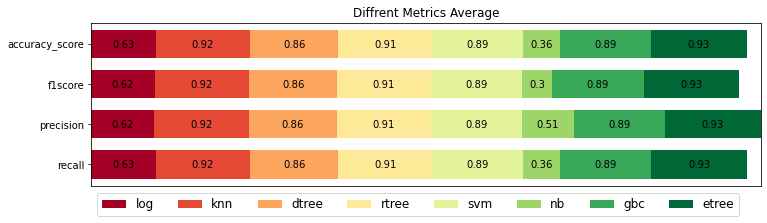

In [62]:
category_names = names
result_data = {"accuracy_score": test_acc, 'f1score':    test_f1, 'precision': test_pre, 'recall':    test_rec,  }

def survey(result_data, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(result_data.keys())
    data = np.array(list(result_data.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0, 1, data.shape[1]))

    fig, ax = plt.subplots(figsize=(12, 3))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())
   

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.7,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color =  'k'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(np.around(c,decimals = 2)), ha='center', va='center',
                    color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, -0.22),
              loc='lower left', fontsize='large')
    ax.set_title('Diffrent Metrics Average', loc='center')
    fig.savefig('fname_macro2', dpi=300)
    return fig, ax


survey(result_data, category_names)
plt.show()

#  np.around(recall, decimals = 2)

##### 3-2 Confusion matrix 

To evaluate the model performance quality, there are several metrics for both regression and classification broblems. In this example that we are dealing with multi-class classification problem, we will calculate some of metrics to evaluate model accuracy. To begin, confusion metrix can be appropriate selection.<br>
Confusion matrix shows predicted class labels against original true label data.

In [63]:
from sklearn.metrics import confusion_matrix
import itertools

In [64]:
# define function to implement confusion matrix with normalization capability
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.savefig('conf20', dpi=300)

After setting up a confusion matrix function, let's build two models(highest and lowest accuracy) employing the best calculated hyper-parameters in the previous section. Then call confusion matrix to caluclate it and plot.

In [65]:
%%time
# create Logistic Reg model with optimom hyper-parameters
model_log=LogisticRegression(C = 10, solver = 'lbfgs', max_iter= 300 ) 
model_log.fit(X_train, y_train)
# predict test labels
y_pred_log = model_log.predict(X_test)

Wall time: 3.04 s


In [66]:
#calculate confusion matrix
cnf_log = confusion_matrix(y_test, y_pred_log)

Confusion matrix, without normalization


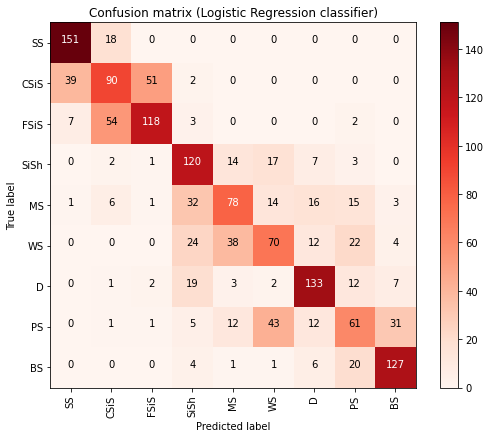

In [67]:
#Plot confusion matrix for RandomForest classifier
fig = plt.figure()
fig.set_size_inches(7.4, 6, forward=False)
plot_confusion_matrix(cnf_log, classes=np.asarray(facies_labels),
                      title='Confusion matrix (Logistic Regression classifier)')

Taking a look at the plot(first row), we recognize that this algorithm could predict 151 SS class correctly while 18 true SS were classified as CSiS incorrectly. From the previous section, we are familiar with the recall concept. From all true class members of SS(169), the classifier could recognize 151 correctly; 151/169 is 89%(we have seen this number in the class report in the picture above). So, we can conclude that if we move our evaluation in the row direction(True labels) we are dealing with recall.
You may guess that if we go in the column direction, we will deal with Precision. For SS precision is 75% as 149/201.

In [68]:
%%time
# create nb model with optimom hyper-parameters
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)
# predict test labels
y_pred_nb = model_nb.predict(X_test)

Wall time: 57 ms


In [69]:
#calculate confusion matrix
cnf_nb = confusion_matrix(y_test, y_pred_nb)

Confusion matrix, without normalization


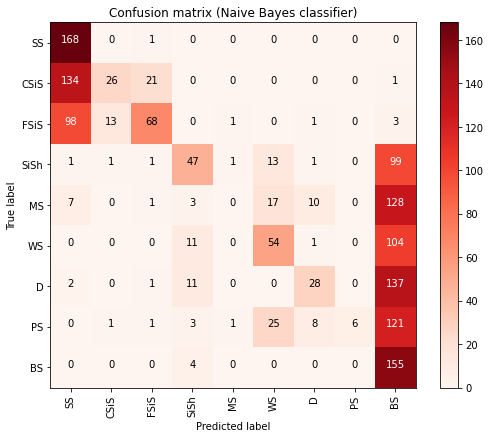

In [70]:
#Plot confusion matrix for RandomForest classifier
fig = plt.figure()
fig.set_size_inches(7.4, 6, forward=True)
plot_confusion_matrix(cnf_nb, classes=np.asarray(facies_labels),
                      title='Confusion matrix (Naive Bayes classifier)')

In the picture below, we see how the Naive Bayes classifier poorly performed prediction. This classifier is totally overestimated BS class in prediction.

#### ^^^^^^^^^^^^^^^^^^^^^^ END of PART 3 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

### References:

1) https://jakevdp.github.io/PythonDataScienceHandbook/index.html <br>
2) https://scikit-learn.org/stable/supervised_learning.html#supervised-learning<br>
3) https://machinelearningmastery.com/<br>
4) [Brendon Hall Git](https://github.com/brendonhall/facies_classification/blob/master/Facies%20Classification%20-%20SVM.ipynb)<br>